In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python import keras

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

df = pd.read_csv('train.csv')

y = df.label

X = df.drop('label',axis=1)
X = X/255
X = X.values.reshape(len(X),img_rows,img_cols,1)

del df

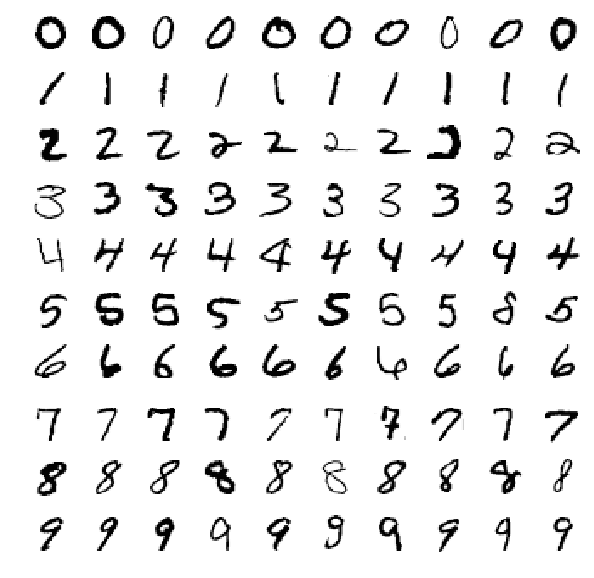

In [3]:
plt.figure(figsize=(10,10))
for i in range(10):
    tmp = X[y==i]
    for j in range(10):
        plt.subplot(10,10,(10*i)+(j+1))
        plt.imshow(tmp[j][:,:,0], cmap='Greys')
        plt.axis('off')